# 导入数据

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 训练集与测试集

In [2]:
train_data=pd.read_csv('D:/titanic/train.csv')
test_data=pd.read_csv('D:/titanic/test.csv')
sns.set_style('whitegrid')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 观察是否有缺失值

In [3]:
train_data.info()
print('-'*40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

# 存在缺失值，需要预处理

## 幸存者数量饼图

<AxesSubplot:ylabel='Survived'>

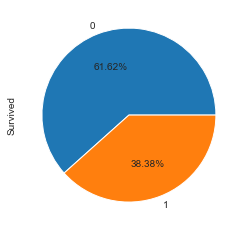

In [4]:
train_data['Survived'].value_counts().plot.pie(autopct='%1.2f%%')

### 由于Embarked，即登船地点，缺失值只有2个，所以使用众数进行填补

In [5]:
train_data.Embarked[train_data.Embarked.isnull()]=train_data.Embarked.mode()

### 将Cabin，即舱室，的缺失值用‘U0’代替，因为舱室确实也有可能是一种特征

In [6]:
train_data['Cabin']=train_data.Cabin.fillna('U0')

### 由于Age缺失值较多，且Age数据很可能重要，所以利用随机森林模型对缺失的Age进行预测

In [7]:
from sklearn.ensemble import RandomForestRegressor

#choose training data to predict age
age_df = train_data[['Age','Survived','Fare', 'Parch', 'SibSp', 'Pclass']]#利用后5项对Age进行预测
age_df_notnull = age_df.loc[(train_data['Age'].notnull())]
age_df_isnull = age_df.loc[(train_data['Age'].isnull())]
X = age_df_notnull.values[:,1:]
Y = age_df_notnull.values[:,0]
# use RandomForestRegression to train data
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RFR.fit(X,Y)
predictAges = RFR.predict(age_df_isnull.values[:,1:])
train_data.loc[train_data['Age'].isnull(), ['Age']]= predictAges

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 观察到无缺失值

# 预处理完毕

### 将数据按照Sex和Survived分组，分成了四组，再对Survived计数

In [9]:
train_data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

### 根据Survived和Sex两列数据，按Sex分组，再求均值并画图

<AxesSubplot:xlabel='Sex'>

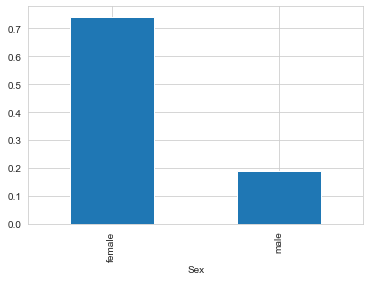

In [10]:
train_data[['Survived','Sex']].groupby(['Sex'])['Survived'].mean().plot.bar()

### 船舱等级与幸存数

In [11]:
train_data.groupby(['Pclass','Survived'])['Pclass'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Pclass, dtype: int64

### 船舱等级与幸存概率

<AxesSubplot:xlabel='Pclass'>

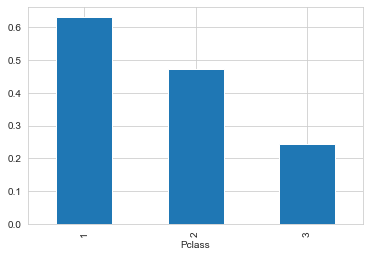

In [12]:
train_data[['Pclass','Survived']].groupby(['Pclass'])['Survived'].mean().plot.bar()

### 船舱等级与性别的幸存率

<AxesSubplot:xlabel='Pclass,Sex'>

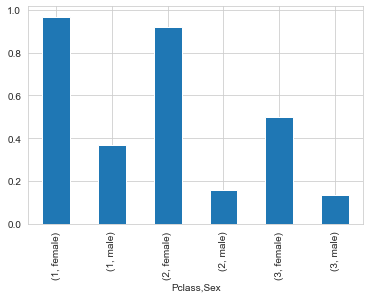

In [13]:
train_data[['Sex','Pclass','Survived']].groupby(['Pclass','Sex'])['Survived'].mean().plot.bar()

### 船舱等级与性别的幸存数

In [14]:
train_data.groupby(['Sex','Pclass','Survived'])['Survived'].count()

Sex     Pclass  Survived
female  1       0             3
                1            91
        2       0             6
                1            70
        3       0            72
                1            72
male    1       0            77
                1            45
        2       0            91
                1            17
        3       0           300
                1            47
Name: Survived, dtype: int64

### 通过小提琴图对船舱等级与不同性别在不同年龄的幸存情况

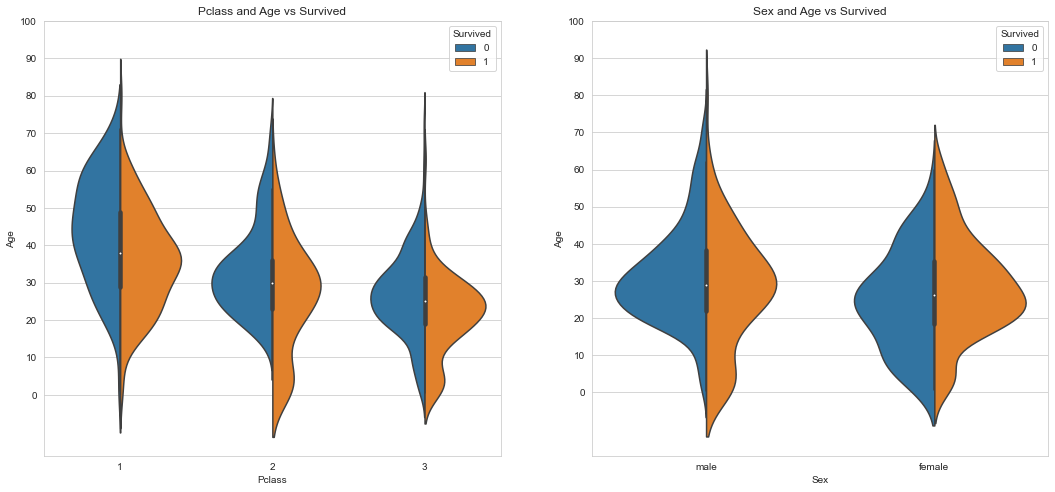

In [15]:
fig,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot('Pclass','Age',hue='Survived',data=train_data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))

sns.violinplot('Sex','Age',hue='Survived',data=train_data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))

plt.show()

### 年龄的分布

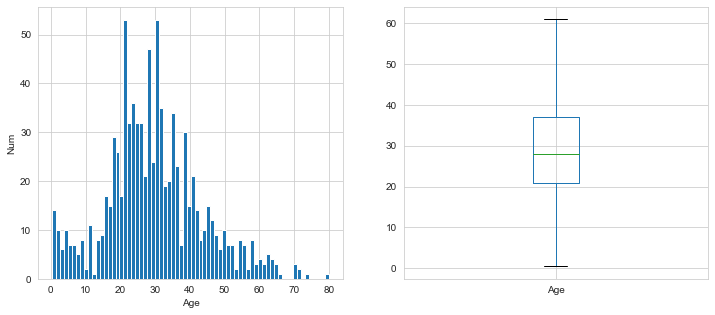

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(121)
train_data['Age'].hist(bins=70)
plt.xlabel('Age')
plt.ylabel('Num')

plt.subplot(122)
train_data.boxplot('Age',showfliers=False)
plt.show()

### 不同年龄的幸存与否的概率密度图

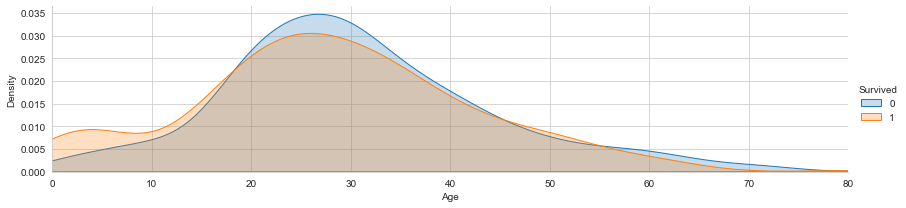

In [17]:
facet=sns.FacetGrid(train_data,hue='Survived',aspect=4)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0,train_data['Age'].max()))
facet.add_legend()

### 各个年龄的幸存概率

<AxesSubplot:xlabel='Age_int', ylabel='Survived'>

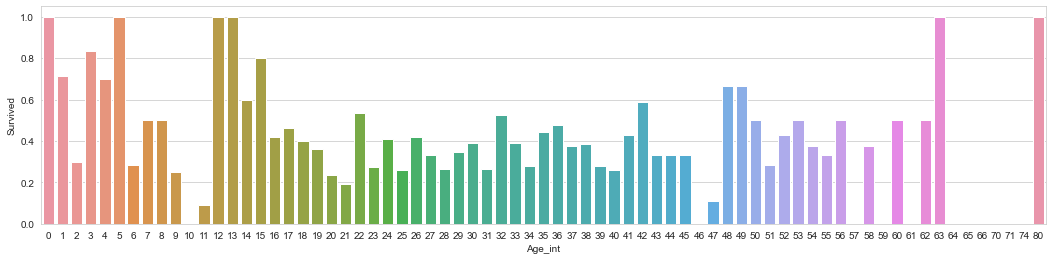

In [18]:
fig,axisl=plt.subplots(1,1,figsize=(18,4))
train_data['Age_int']=train_data['Age'].astype(int)
average_age=train_data[['Age_int','Survived']].groupby(['Age_int'],as_index=False).mean()
sns.barplot(x='Age_int',y='Survived',data=average_age)

In [19]:
train_data['Age'].describe()

count    891.000000
mean      29.658850
std       13.741586
min        0.420000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

### 将年龄分成四组，求每组的幸存率

In [20]:
bins=[0,12,18,65,100]
train_data['Age_group']=pd.cut(train_data['Age'],bins)
by_age=train_data.groupby('Age_group')['Survived'].mean()
by_age

Age_group
(0, 12]      0.506173
(12, 18]     0.466667
(18, 65]     0.364512
(65, 100]    0.125000
Name: Survived, dtype: float64

### 四组幸存率的直方图

<AxesSubplot:xlabel='Age_group'>

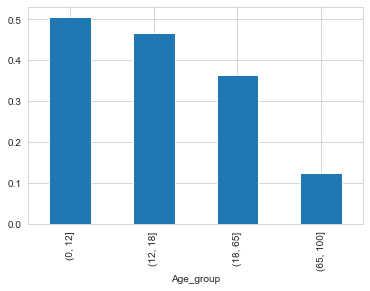

In [21]:
by_age.plot(kind='bar')

### 提取所有Name列里的[大写字母 任意多个小写字母 英文句号]的字节

In [22]:
train_data['Title']=train_data['Name'].str.extract(' ([A-Z][a-z]+)\.',expand=False)
pd.crosstab(train_data['Title'],train_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


### 各个称呼的幸存率

<AxesSubplot:xlabel='Title'>

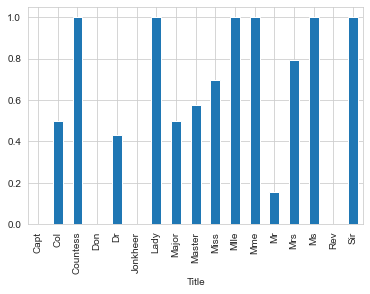

In [23]:
train_data[['Title','Survived']].groupby(['Title'])['Survived'].mean().plot.bar()

### 计算各个姓名长度的幸存率

<AxesSubplot:xlabel='Name_length', ylabel='Survived'>

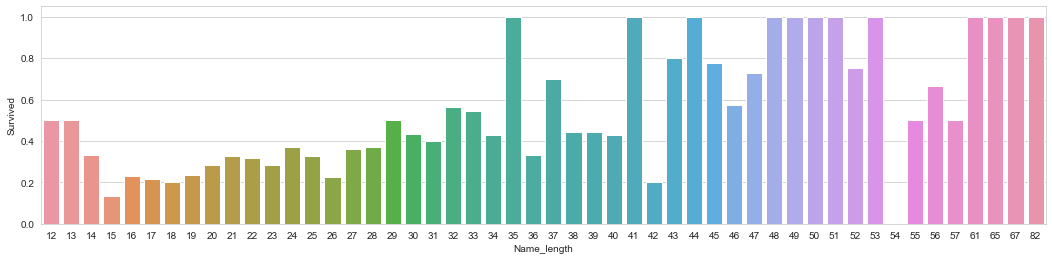

In [24]:
plt.subplots(1,1,figsize=(18,4))
train_data['Name_length']=train_data['Name'].apply(len)
name_length=train_data[['Name_length','Survived']].groupby(['Name_length'],as_index=False)['Survived'].mean()
sns.barplot(x='Name_length',y='Survived',data=name_length)

### 将数据分为有无兄弟姐妹两组

In [25]:
sibsp_df=train_data[train_data['SibSp']!=0]
no_sibsp_df=train_data[train_data['SibSp']==0]


### 用value_counts()函数分别对有无兄弟姐妹的数据进行计数，并画饼图

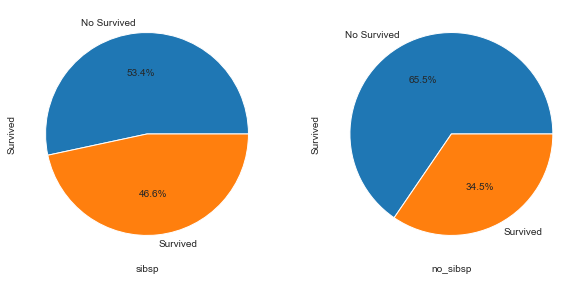

In [26]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct='%1.1f%%')
plt.xlabel('sibsp')
plt.subplot(122)
no_sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct='%1.1f%%')
plt.xlabel('no_sibsp')
plt.show()

### 有无父母孩子的两组的幸存率

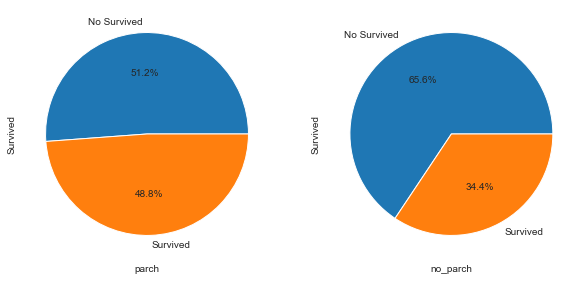

In [27]:
parch_df=train_data[train_data['Parch']!=0]
no_parch_df=train_data[train_data['Parch']==0]

plt.figure(figsize=(10,5))
plt.subplot(121)
parch_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct='%1.1f%%')
plt.xlabel('parch')

plt.subplot(122)
no_parch_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct='%1.1f%%')
plt.xlabel('no_parch')

plt.show()

### 不同个数父母孩子与不同个数兄弟姐妹的幸存率直方图

Text(0.5, 1.0, 'Sibsp and Survived')

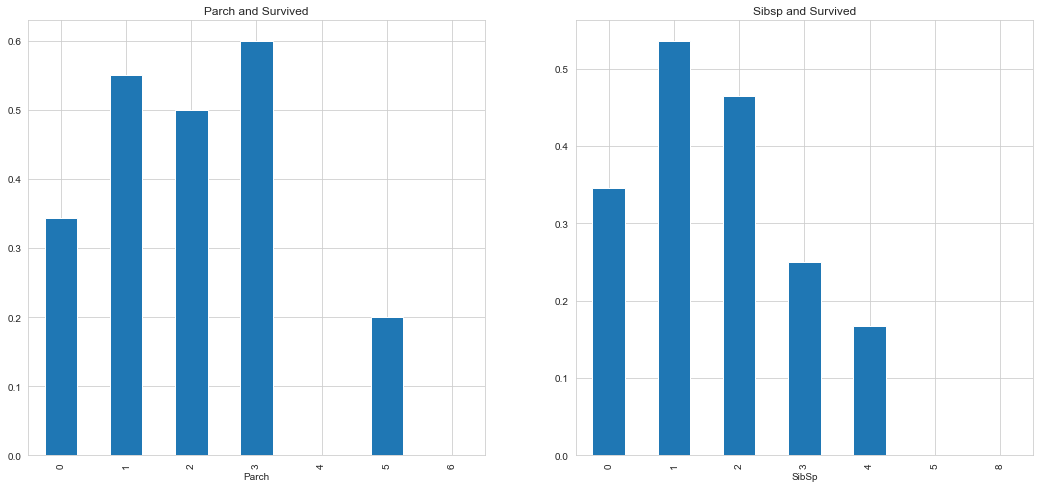

In [28]:
plt.figure(figsize=(18,8))
plt.subplot(121)
train_data[['Parch','Survived']].groupby('Parch')['Survived'].mean().plot.bar()
plt.title('Parch and Survived')

plt.subplot(122)
train_data[['SibSp','Survived']].groupby('SibSp')['Survived'].mean().plot.bar()
plt.title('Sibsp and Survived')



### 将所有亲戚都加上，可以看出独自一人幸存率较低，家庭成员数量过大，幸存率也会降低

<AxesSubplot:xlabel='Family_Size'>

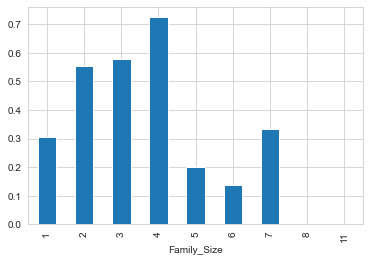

In [29]:
train_data['Family_Size']=train_data['Parch']+train_data['SibSp']+1
train_data[['Family_Size','Survived']].groupby(['Family_Size'])['Survived'].mean().plot.bar()

### 票价的分布情况

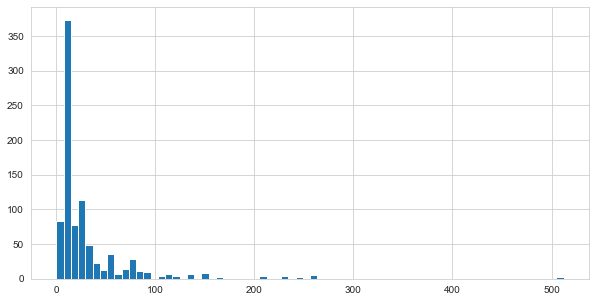

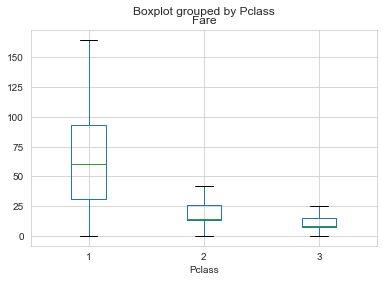

In [30]:
plt.figure(figsize=(10,5))
train_data['Fare'].hist(bins=70)

train_data.boxplot(column='Fare',by='Pclass',showfliers=False)
plt.show()

In [31]:
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

### 绘制幸存与否与票价的关系

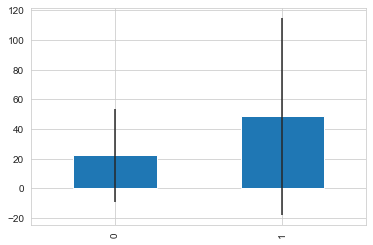

In [32]:
fare_not_survived=train_data['Fare'][train_data['Survived']==0]
fare_survived=train_data['Fare'][train_data['Survived']==1]

average_fare=pd.DataFrame([fare_not_survived.mean(),fare_survived.mean()])
std_fare=pd.DataFrame([fare_not_survived.std(),fare_survived.std()])
average_fare.plot(yerr=std_fare,kind='bar',legend=False)

plt.show()

### 是否有记录客舱的幸存率

<AxesSubplot:xlabel='Has_Cabin'>

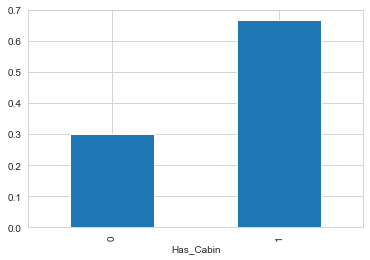

In [33]:
train_data['Has_Cabin']=train_data['Cabin'].apply(lambda x: 0 if x=='U0' else 1)
train_data[['Has_Cabin','Survived']].groupby('Has_Cabin')['Survived'].mean().plot.bar()

### 不同客舱首字母的幸存率

<AxesSubplot:xlabel='CabinLetter'>

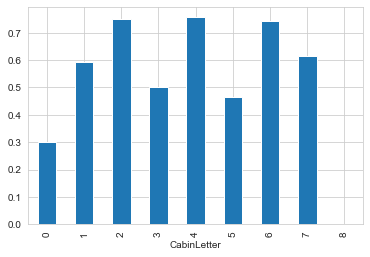

In [34]:
train_data['CabinLetter']=train_data['Cabin'].map(lambda x: re.compile('[A-Z]').search(x).group())
train_data['CabinLetter']=pd.factorize(train_data['CabinLetter'])[0]
train_data[['CabinLetter','Survived']].groupby(['CabinLetter'])['Survived'].mean().plot.bar()

### 不同上船地的幸存率

Text(0.5, 1.0, 'Embarked and Survived')

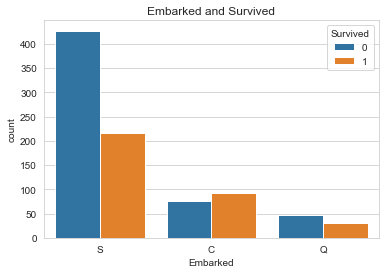

In [35]:
sns.countplot('Embarked',hue='Survived',data=train_data)
plt.title('Embarked and Survived')


### 不同上船地的幸存率

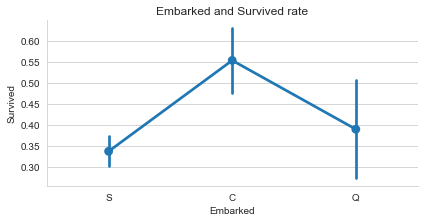

In [36]:
sns.factorplot('Embarked','Survived',data=train_data,size=3,aspect=2)
plt.title('Embarked and Survived rate')
plt.show()

### 另外还有数据集中没有分析的几个特征：Ticket（船票号）、Cabin（船舱号）,这些因素的不同可能会影响乘客在船中的位置从而影响逃生的顺序。但是船舱号数据缺失，船票号类别大，难以分析规律，所以在后期模型融合的时候，将这些因素交由模型来决定其重要性。

# 变量转换（定性）

### 将Embarked分为3列数据加入train_data中，再删去Embarked特征，实现特征转换

In [37]:
embark_dummies=pd.get_dummies(train_data['Embarked'])
train_data=train_data.join(embark_dummies)
train_data.drop(['Embarked'],axis=1,inplace=True)

embark_dummies=train_data[['S','C','Q']]
embark_dummies.head()

,S,C,Q
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


### 将客舱按照首字母进行分类

In [38]:

train_data['CabinLetter']=train_data['Cabin'].map(lambda x : re.compile('[A-Z]').search(x).group())

train_data['CabinLetter']=pd.factorize(train_data['CabinLetter'])[0]

train_data['CabinLetter'].head()

0    0
1    1
2    0
3    1
4    0
Name: CabinLetter, dtype: int64

### 对Age数据进行标准化，结果放在Age_scaled里

In [39]:
from sklearn import preprocessing

assert np.size(train_data['Age'])==891

scaler=preprocessing.StandardScaler()
train_data['Age_scaled']=scaler.fit_transform(train_data['Age'].values.reshape(-1,1))
train_data['Age_scaled'].head()

0   -0.557661
1    0.607341
2   -0.266411
3    0.388903
4    0.388903
Name: Age_scaled, dtype: float64

### 将票价分成分成5分数量相等的组

In [40]:
train_data['Fare_bin']=pd.qcut(train_data['Fare'],5)
train_data['Fare_bin'].head()

0      (-0.001, 7.854]
1    (39.688, 512.329]
2        (7.854, 10.5]
3    (39.688, 512.329]
4        (7.854, 10.5]
Name: Fare_bin, dtype: category
Categories (5, interval[float64, right]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.679] < (21.679, 39.688] < (39.688, 512.329]]

### 将分好的5组增加组索引，并将索引分成5列添加到train_data后面

In [41]:
train_data['Fare_bin_id']=pd.factorize(train_data['Fare_bin'])[0]

fare_bin_dummies_df=pd.get_dummies(train_data['Fare_bin']).rename(columns=lambda x :'Fare' + str(x))
train_data=pd.concat([train_data,fare_bin_dummies_df],axis=1)

# 特征工程

### 重新导入一批新数据

In [42]:
train_df_org=pd.read_csv('D:/titanic/train.csv')
test_df_org=pd.read_csv('D:/titanic/test.csv')
test_df_org['Survived']=0
combined_train_test=train_df_org.append(test_df_org)
PassengerId=test_df_org['PassengerId']

### 用众数填补上船地的缺失值

In [43]:
combined_train_test['Embarked'].fillna(combined_train_test['Embarked'].mode().iloc[0],inplace=True)

### 将上船地分成三组列向量

In [44]:
combined_train_test['Embarked']=pd.factorize(combined_train_test['Embarked'])[0]

emb_dummies_df=pd.get_dummies(combined_train_test['Embarked'],prefix=combined_train_test[['Embarked']].columns[0])
combined_train_test=pd.concat([combined_train_test,emb_dummies_df],axis=1)

### 将性别分成两组列向量

In [45]:
combined_train_test['Sex']=pd.factorize(combined_train_test['Sex'])[0]

sex_dummies_df=pd.get_dummies(combined_train_test['Sex'],prefix=combined_train_test[['Sex']].columns[0])
combined_train_test=pd.concat([combined_train_test,sex_dummies_df],axis=1)

### 提取所有乘客姓名的称呼

In [46]:
combined_train_test['Title']=combined_train_test['Name'].map(lambda x: re.compile(",(.*?)\.").findall(x)[0])



### 将Title中所有称呼进行按类别替换

In [47]:

title_Dict={}
title_Dict.update(dict.fromkeys(['Capt','Col','Major','Dr','Rev'],'Officer'))
title_Dict.update(dict.fromkeys(['Don','Sir','the Countess','Dona','Lady'],'Royalty'))
title_Dict.update(dict.fromkeys(['Mme','Ms','Mrs'],'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle','Miss'],'Miss'))
title_Dict.update(dict.fromkeys(['Mr'],'Mr'))
title_Dict.update(dict.fromkeys(['Master','Jonkheer'],'Master'))
combined_train_test['Title'].update(combined_train_test['Title'].map(title_Dict))

### 将Title中的类别按组分成数字

In [48]:
combined_train_test['Title']=pd.factorize(combined_train_test['Title'])[0]

title_dummies_df=pd.get_dummies(combined_train_test['Title'],prefix=combined_train_test[['Title']].columns[0])
combined_train_test=pd.concat([combined_train_test,title_dummies_df],axis=1)

### 增加一个特征，姓名长度

In [49]:
combined_train_test['Name_length']=combined_train_test['Name'].apply(len)

### 用不同船舱等级的平均价格给Fare补缺失值

In [50]:
combined_train_test['Fare']=combined_train_test['Fare'].fillna(combined_train_test.groupby('Pclass')['Fare'].transform(np.mean))


### 对票据编号用groupby，可以查出团体票的情况，用GroupTicket表示团体票的人数，每个人的团体票价格为Fare价格除以人数
### 最后把Group_Ticket列删掉

In [51]:
combined_train_test['Group_Ticket']=combined_train_test['Fare'].groupby(by=combined_train_test['Ticket']).transform('count')
combined_train_test['Fare']=combined_train_test['Fare'] / combined_train_test['Group_Ticket']
combined_train_test.drop(['Group_Ticket'],axis=1,inplace=True)

### 将票价分为5个相等的组

In [52]:
combined_train_test['Fare_bin']=pd.qcut(combined_train_test['Fare'],5)


### 将分好的5组变成5列Fare1，Fare2...的特征

In [53]:
combined_train_test['Fare_bin_id']=pd.factorize(combined_train_test['Fare_bin'])[0]

fare_bin_dummies_df=pd.get_dummies(combined_train_test['Fare_bin_id']).rename(columns=lambda x:'Fare'+str(x))
combined_train_test=pd.concat([combined_train_test,fare_bin_dummies_df],axis=1)
combined_train_test.drop(['Fare_bin'],axis=1,inplace=True)

### 将3种船舱等级按组内价格再分出组内高价与组内低价6种，再将6中转化为6列数字

In [54]:
from sklearn.preprocessing import LabelEncoder

def pclass_fare_category(df,pclass1_mean_fare,pclass2_mean_fare,pclass3_mean_fare):
    if df['Pclass']==1:
        if df['Fare']<=pclass1_mean_fare:
            return 'Pclass1_Low'
        else:
            return 'Pclass1_High'
    elif df['Pclass']==2:
        if df['Fare']<=pclass2_mean_fare:
            return 'Pclass2_Low'
        else:
            return 'Pclass2_High'
    else:
        if df['Fare']<=pclass3_mean_fare:
            return 'Pclass3_Low'
        else:
            return 'Pclass3_High'
        
Pclass1_mean_fare=combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([1]).values[0]
Pclass2_mean_fare=combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([2]).values[0]
Pclass3_mean_fare=combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([3]).values[0]

combined_train_test['Pclass_Fare_Category']=combined_train_test.apply(pclass_fare_category,args=(
    Pclass1_mean_fare,Pclass2_mean_fare,Pclass3_mean_fare),axis=1)
pclass_level=LabelEncoder()

pclass_level.fit(np.array(
['Pclass1_Low','Pclass1_High','Pclass2_Low','Pclass2_High','Pclass3_Low','Pclass3_High']))

combined_train_test['Pclass_Fare_Category']=pclass_level.transform(combined_train_test['Pclass_Fare_Category'])

pclass_dummies_df=pd.get_dummies(combined_train_test['Pclass_Fare_Category']).rename(columns=lambda x:'Pclass'+str(x))
combined_train_test=pd.concat([combined_train_test,pclass_dummies_df],axis=1)

combined_train_test['Pclass']=pd.factorize(combined_train_test['Pclass'])[0]

### 将父母孩子和兄弟姐妹合并成家庭大小，按家庭大小的人数分成三类，再将三类变成三个数字特征

In [55]:
def family_size_category(family_size):
    if family_size<=1:
        return 'Single'
    elif family_size<=4:
        return 'Small_Family'
    else:
        return 'Large_Family'
    
combined_train_test['Family_Size']=combined_train_test['Parch']+combined_train_test['SibSp']+1
combined_train_test['Family_Size_Category']=combined_train_test['Family_Size'].map(family_size_category)

le_family=LabelEncoder()
le_family.fit(np.array(['Single','Small_Family','Large_Family']))
combined_train_test['Family_Size_Category']=le_family.transform(combined_train_test['Family_Size_Category'])

family_size_dummies_df=pd.get_dummies(combined_train_test['Family_Size_Category'],
                                     prefix=combined_train_test[['Family_Size_Category']].columns[0])
combined_train_test=pd.concat([combined_train_test,family_size_dummies_df],axis=1)



### 将Age的缺失值与已知值分开，接下来利用模型对缺失值进行拟合

In [56]:
missing_age_df=pd.DataFrame(combined_train_test[
    ['Age','Embarked','Sex','Title','Name_length','Family_Size','Family_Size_Category','Fare','Fare_bin_id','Pclass']])

missing_age_train=missing_age_df[missing_age_df['Age'].notnull()]
missing_age_test=missing_age_df[missing_age_df['Age'].isnull()]
missing_age_test.head()

,Age,Embarked,Sex,Title,Name_length,Family_Size,Family_Size_Category,Fare,Fare_bin_id,Pclass
5,NaN,2,0,0,16,1,1,8.4583,2,0
17,NaN,0,0,0,28,1,1,13.0000,3,2
19,NaN,1,1,1,23,1,1,7.2250,4,0
26,NaN,1,0,0,23,1,1,7.2250,4,0
28,NaN,2,1,2,29,1,1,7.8792,0,0


### 此函数利用梯度提升决策树与随机森林算法，对Age进行拟合，10折交叉验证，结果用两种算法预测的均值

In [57]:
from sklearn import ensemble
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

def fill_missing_age(missing_age_train,missing_age_test):
    missing_age_X_train=missing_age_train.drop(['Age'],axis=1)
    missing_age_Y_train=missing_age_train['Age']
    missing_age_X_test=missing_age_test.drop(['Age'],axis=1)
    
    #model 1 gbm
    gbm_reg=GradientBoostingRegressor(random_state=42)
    gbm_reg_param_grid={'n_estimators':[2000],'max_depth':[4],'learning_rate':[0.01],'max_features':[3]}
    gbm_reg_grid=model_selection.GridSearchCV(gbm_reg,gbm_reg_param_grid,cv=10,n_jobs=25,verbose=1,scoring='neg_mean_squared_error')
    gbm_reg_grid.fit(missing_age_X_train,missing_age_Y_train)
    print('Age feature Best GB Params:'+str(gbm_reg_grid.best_params_))
    print('Age feature Best GB Score:'+str(gbm_reg_grid.best_score_))
    print('GB Train Error for "Age" Feature Regressor:'+str(gbm_reg_grid.score(missing_age_X_train,missing_age_Y_train)))
    missing_age_test.loc[:,'Age_GB']=gbm_reg_grid.predict(missing_age_X_test)
    print(missing_age_test['Age_GB'][:4])
    
    #model 2 rf
    rf_reg=RandomForestRegressor()
    rf_reg_param_grid={'n_estimators':[200],'max_depth':[5],'random_state':[0]}
    rf_reg_grid=model_selection.GridSearchCV(rf_reg,rf_reg_param_grid,cv=10,n_jobs=25,verbose=1,scoring='neg_mean_squared_error')
    rf_reg_grid.fit(missing_age_X_train,missing_age_Y_train)
    print('Age feature Best RF Params:'+str(rf_reg_grid.best_params_))
    print('Age feature Best RF Score:'+str(rf_reg_grid.best_score_))
    print('RF Train Error for "Age" Feature Regressor'+str(rf_reg_grid.score(missing_age_X_train,missing_age_Y_train)))
    missing_age_test.loc[:,'Age_RF']=rf_reg_grid.predict(missing_age_X_test)
    print(missing_age_test['Age_RF'][:4])
    
    
    print('shape1',missing_age_test['Age'].shape,missing_age_test[['Age_GB','Age_RF']].mode(axis=1).shape)
    
    
    missing_age_test.loc[:,'Age']=np.mean([missing_age_test['Age_GB'],missing_age_test['Age_RF']])
    print(missing_age_test['Age'][:4])
    
    missing_age_test.drop(['Age_GB','Age_RF'],axis=1,inplace=True)
    
    return missing_age_test
    
    
    

### 拟合结果

In [58]:
combined_train_test.loc[(combined_train_test.Age.isnull()),'Age']=fill_missing_age(missing_age_train,missing_age_test)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Age feature Best GB Params:{'learning_rate': 0.01, 'max_depth': 4, 'max_features': 3, 'n_estimators': 2000}
Age feature Best GB Score:-129.19509552364156
GB Train Error for "Age" Feature Regressor:-64.15040141257515
5     36.349665
17    31.507625
19    35.681250
26    28.705545
Name: Age_GB, dtype: float64
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Age feature Best RF Params:{'max_depth': 5, 'n_estimators': 200, 'random_state': 0}
Age feature Best RF Score:-119.52255761794602
RF Train Error for "Age" Feature Regressor-95.98678822387993
5     33.153409
17    33.034343
19    34.942613
26    28.155912
Name: Age_RF, dtype: float64
shape1 (263,) (263, 2)
5     29.896
17    29.896
19    29.896
26    29.896
Name: Age, dtype: float64


### 将Ticket特征中英文与数字部分分开,提取前面部分

In [59]:
combined_train_test['Ticket_Letter']=combined_train_test['Ticket'].str.split().str[0]
combined_train_test['Ticket_Letter']=combined_train_test['Ticket_Letter'].apply(lambda x:'U0' if x.isnumeric() else x)
print(combined_train_test['Ticket_Letter'])
combined_train_test['Ticket_Letter']=pd.factorize(combined_train_test['Ticket_Letter'])[0]


0             A/5
1              PC
2        STON/O2.
3              U0
4              U0
          ...    
413          A.5.
414            PC
415    SOTON/O.Q.
416            U0
417            U0
Name: Ticket_Letter, Length: 1309, dtype: object


### 将Cabin组分成有无数据两种

In [60]:
combined_train_test.loc[combined_train_test.Cabin.isnull(),'Cabin']='U0'
combined_train_test['Cabin']=combined_train_test['Cabin'].apply(lambda x:0 if x=='U0' else 1)


### 挑选一些特征，看看特征间的相关性

In [61]:
Correlation=pd.DataFrame(combined_train_test[
    ['Embarked','Sex','Title','Name_length','Family_Size','Family_Size_Category','Fare','Fare_bin_id','Pclass',
    'Pclass_Fare_Category','Age','Ticket_Letter','Cabin']])



### 皮尔逊相关系数，正负表示正负相关，绝对值越大，相关性越高

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

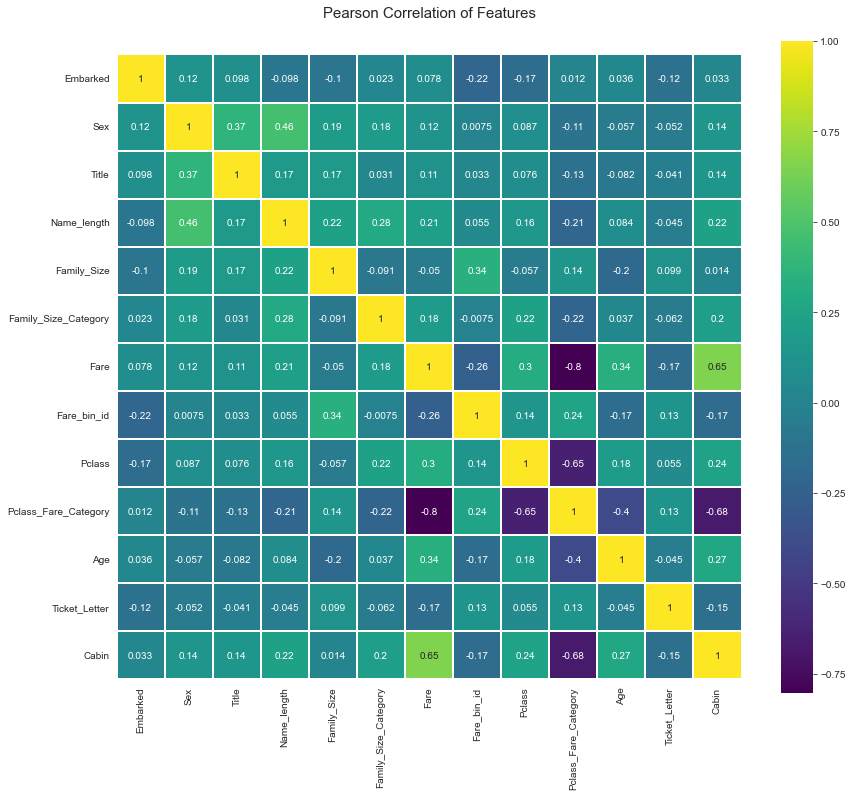

In [62]:
colormap=plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features',y=1.05,size=15)
sns.heatmap(Correlation.astype(float).corr(),linewidth=0.1,vmax=1.0,square=True,cmap=colormap,linecolor='white',annot=True)

### 特征间的数据分布图

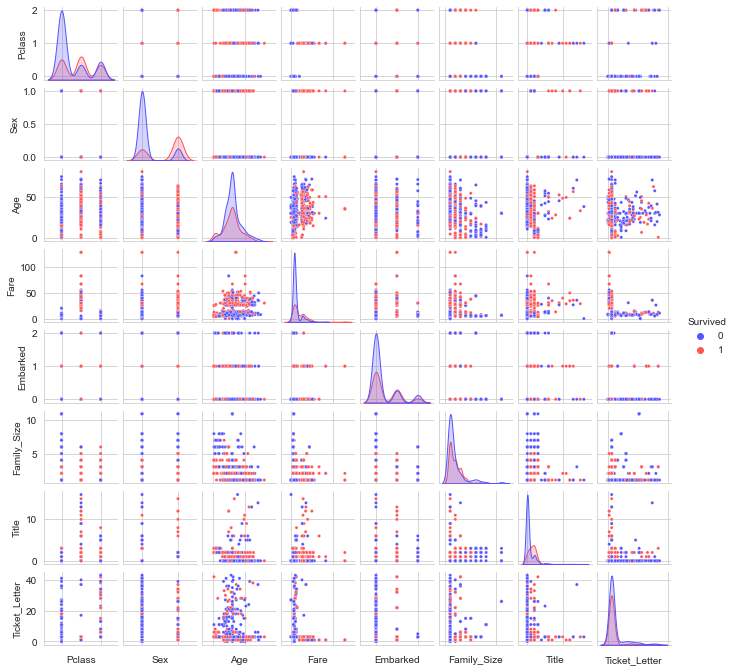

In [63]:
gg=combined_train_test[['Survived','Pclass','Sex','Age','Fare','Embarked',
                                   'Family_Size','Title','Ticket_Letter']]

ggg=gg[~gg.index.duplicated()]

g=sns.pairplot(ggg,hue='Survived',palette='seismic',size=1.2,diag_kind='kde',diag_kws=dict(shade=True),plot_kws=dict(s=10))
g.set(xticklabels=[])

### 计算出均值与方差存入scale_age_fare，然后利用它对数据进行标准化

In [64]:
scale_age_fare=preprocessing.StandardScaler().fit(combined_train_test[['Age','Fare','Name_length']])
combined_train_test[['Age','Fare','Name_length']]=scale_age_fare.transform(combined_train_test[['Age','Fare','Name_length']])

### 备份

In [65]:
combined_data_backup=combined_train_test

### 弃掉无用特征

In [66]:
combined_train_test.drop(['PassengerId','Embarked','Sex','Name','Title','Fare_bin_id','Pclass_Fare_Category',
                         'Parch','SibSp','Family_Size_Category','Ticket'],axis=1,inplace=True)


### 将训练集与测试集分开

In [67]:
train_data=combined_train_test[:891]
test_data=combined_train_test[891:]

titanic_train_data_X=train_data.drop(['Survived'],axis=1)
titanic_train_data_Y=train_data['Survived']
titanic_test_data_X=test_data.drop(['Survived'],axis=1)

In [68]:
titanic_train_data_X.shape

(891, 44)

### 由于特征间具有相关性，所以利用5种不同算法对最重要的n种特征进行挑选

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

def get_top_n_features(titanic_train_data_X,titanic_train_data_Y,top_n_features):

    # random forest
    rf_est=RandomForestClassifier(random_state=0)
    rf_param_grid={'n_estimators':[500],'min_samples_split':[2,3],'max_depth':[20]}
    rf_grid=model_selection.GridSearchCV(rf_est,rf_param_grid,n_jobs=25,cv=10,verbose=1)
    rf_grid.fit(titanic_train_data_X,titanic_train_data_Y)
    print('Top N Features Best RF Params:'+str(rf_grid.best_params_))
    print('Top N Features Best RF Score:'+str(rf_grid.best_score_))
    print('Top N Features RF Train Score:'+str(rf_grid.score(titanic_train_data_X,titanic_train_data_Y)))
    feature_imp_sorted_rf=pd.DataFrame({'feature':list(titanic_train_data_X),
                                       'importance':rf_grid.best_estimator_.feature_importances_}).sort_values('importance',ascending=False)
    features_top_n_rf=feature_imp_sorted_rf.head(top_n_features)['feature']
    print('Sample 10 Features from RF Classifier')
    print(str(features_top_n_rf[:10]))
    
    # AdaBoost
    ada_est=AdaBoostClassifier(random_state=0)
    ada_param_grid={'n_estimators':[500],'learning_rate':[0.01,0.1]}
    ada_grid=model_selection.GridSearchCV(ada_est,ada_param_grid,n_jobs=25,cv=10,verbose=1)
    ada_grid.fit(titanic_train_data_X,titanic_train_data_Y)
    print('Top N Features Best Ada Params:'+str(ada_grid.best_params_))
    print('Top N Features Best Ada Score:'+str(ada_grid.best_score_))
    print('Top N Features Ada Train Score:'+str(ada_grid.score(titanic_train_data_X,titanic_train_data_Y)))
    feature_imp_sorted_ada=pd.DataFrame({'feature':list(titanic_train_data_X),
                                        'importance':ada_grid.best_estimator_.feature_importances_}).sort_values('importance',ascending=False)
    features_top_n_ada=feature_imp_sorted_ada.head(top_n_features)['feature']
    print('Sample 10 Feature from Ada Classifier:')
    print(str(features_top_n_ada[:10]))
    
    # ExtraTree
    et_est=ExtraTreesClassifier(random_state=0)
    et_param_grid={'n_estimators':[500],'min_samples_split':[3,4],'max_depth':[20]}
    et_grid=model_selection.GridSearchCV(et_est,et_param_grid,n_jobs=25,cv=10,verbose=1)
    et_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best ET Params:' + str(et_grid.best_params_))
    print('Top N Features Best ET Score:'+str(et_grid.best_score_))
    print('Top N Features ET Train Score:'+str(et_grid.score(titanic_train_data_X,titanic_train_data_Y)))
    feature_imp_sorted_et=pd.DataFrame({'feature':list(titanic_train_data_X),
                                       'importance':et_grid.best_estimator_.feature_importances_}).sort_values('importance',ascending=False)
    features_top_n_et=feature_imp_sorted_et.head(top_n_features)['feature']
    print('Sample 10 Features from ET Classifier:')
    print(str(features_top_n_et[:10]))
    
    # GradirntBoosting
    gb_est=GradientBoostingClassifier(random_state=0)
    gb_param_grid={'n_estimators':[500],'learning_rate':[0.01,0.1],'max_depth':[20]}
    gb_grid=model_selection.GridSearchCV(gb_est,gb_param_grid,n_jobs=25,cv=10,verbose=1)
    gb_grid.fit(titanic_train_data_X,titanic_train_data_Y)
    print('Top N Features Best GB Params:'+str(gb_grid.best_params_))
    print('Top N Features Best GB Score:'+str(gb_grid.best_score_))
    print('Top N Features GB Train Score:'+str(gb_grid.score(titanic_train_data_X,titanic_train_data_Y)))
    feature_imp_sorted_gb=pd.DataFrame({'feature':list(titanic_train_data_X),
                                       'importance':gb_grid.best_estimator_.feature_importances_}).sort_values('importance',ascending=False)
    features_top_n_gb=feature_imp_sorted_gb.head(top_n_features)['feature']
    print('Sample 10 Feature from GB Classifier:')
    print(str(features_top_n_gb[:10]))
    
    # DecisionTree
    dt_est=DecisionTreeClassifier(random_state=0)
    dt_param_grid={'min_samples_split':[2,4],'max_depth':[20]}
    dt_grid=model_selection.GridSearchCV(dt_est,dt_param_grid,n_jobs=25,cv=10,verbose=1)
    dt_grid.fit(titanic_train_data_X,titanic_train_data_Y)
    print('Top N Features Best DT Params:'+str(dt_grid.best_params_))
    print('Top N Features Best DT Score:'+str(dt_grid.best_score_))
    print('Top N Features DT Train Score:'+str(dt_grid.score(titanic_train_data_X,titanic_train_data_Y)))
    feature_imp_sorted_dt=pd.DataFrame({'feature':list(titanic_train_data_X),
                                       'importance':dt_grid.best_estimator_.feature_importances_}).sort_values('importance',ascending=False)
    features_top_n_dt=feature_imp_sorted_dt.head(top_n_features)['feature']
    print('Sample 10 Features from DT Classifier:')
    print(str(features_top_n_dt[:10]))
    
    # merge the three models
    features_top_n=pd.concat([features_top_n_rf,features_top_n_ada,features_top_n_et,features_top_n_gb,features_top_n_dt],
                            ignore_index=True).drop_duplicates()
    features_importance=pd.concat([feature_imp_sorted_rf,feature_imp_sorted_ada,feature_imp_sorted_et,
                                  feature_imp_sorted_gb,feature_imp_sorted_dt],ignore_index=True)
    
    return features_top_n,features_importance

### 挑选30种最重要的特征

In [70]:
feature_to_pick=30
feature_top_n,feature_importance=get_top_n_features(titanic_train_data_X,titanic_train_data_Y,feature_to_pick)
titanic_train_data_X=pd.DataFrame(titanic_train_data_X[feature_top_n])
titanic_test_data_X=pd.DataFrame(titanic_test_data_X[feature_top_n])

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Top N Features Best RF Params:{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best RF Score:0.8283021223470662
Top N Features RF Train Score:0.978675645342312
Sample 10 Features from RF Classifier
27      Name_length
1               Age
2              Fare
7             Sex_0
9           Title_0
8             Sex_1
39      Family_Size
0            Pclass
43    Ticket_Letter
11          Title_2
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Top N Features Best Ada Params:{'learning_rate': 0.1, 'n_estimators': 500}
Top N Features Best Ada Score:0.819338327091136
Top N Features Ada Train Score:0.8406285072951739
Sample 10 Feature from Ada Classifier:
1                        Age
2                       Fare
27               Name_length
43             Ticket_Letter
12                   Title_3
39               Family_Size
40    Family_Size_Category_0
0      

### 不同算法对特征排序的可视化

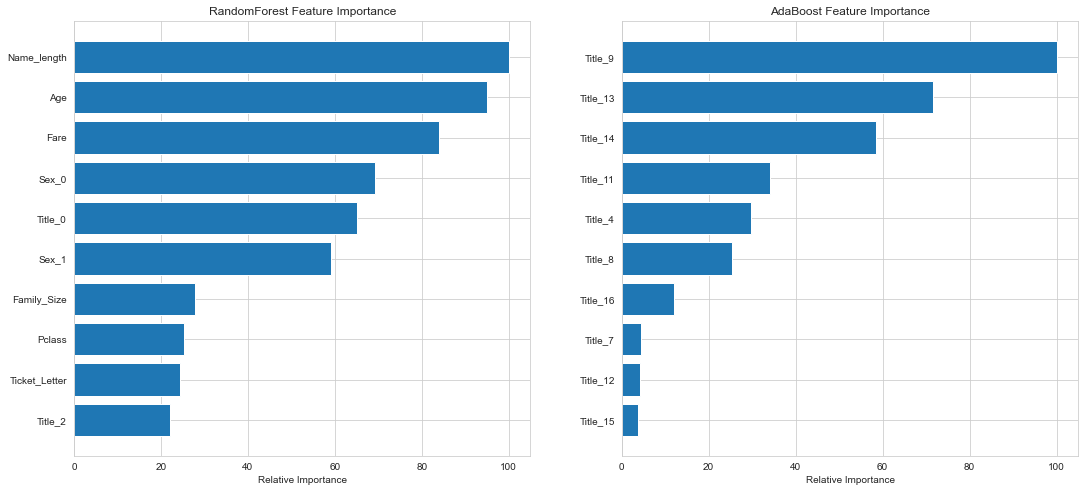

In [71]:
rf_feature_imp=feature_importance[:10]
Ada_feature_imp=feature_importance[32:32+10].reset_index(drop=True)

# make importances relative to max importance
rf_feature_importance=100.0*(rf_feature_imp['importance']/rf_feature_imp['importance'].max())
Ada_feature_importance=100.0*(Ada_feature_imp['importance']/Ada_feature_imp['importance'].max())

# Get the indexes of all features over the importance threshold
rf_important_idx=np.where(rf_feature_importance)[0]
Ada_important_idx=np.where(Ada_feature_importance)[0]

# Adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
pos=np.arange(rf_important_idx.shape[0])+.5

plt.figure(1,figsize=(18,8))

plt.subplot(121)
plt.barh(pos,rf_feature_importance[rf_important_idx][::-1])
plt.yticks(pos,rf_feature_imp['feature'][::-1])
plt.xlabel('Relative Importance')
plt.title('RandomForest Feature Importance')

plt.subplot(122)
plt.barh(pos,Ada_feature_importance[Ada_important_idx][::-1])
plt.yticks(pos,Ada_feature_imp['feature'][::-1])
plt.xlabel('Relative Importance')
plt.title('AdaBoost Feature Importance')

plt.show()


# 接下来对结果进行预测，首先level1利用7种算法对最终结果进行预测，然后level2利用XGBoost将level1的预测结果作为特征对最终结果进行预测

### 创建交叉验证函数，输入预测函数，训练集与测试集，返回交叉验证结果和预测结果

In [72]:
from sklearn.model_selection import KFold

# Some useful parameters which will come in handy later on 
ntrain=titanic_train_data_X.shape[0]
ntest=titanic_test_data_X.shape[0]
SEED=0 # for reproducibility
NFOLDS=7 # set folds for out-of-fold prediction
kf=KFold(n_splits=NFOLDS,random_state=SEED,shuffle=True)

def get_out_fold(clf,x_train,y_train,x_test):
    oof_train=np.zeros((ntrain,))
    oof_test=np.zeros((ntest,))
    oof_test_skf=np.empty((NFOLDS,ntest))
    
    for i, (train_index,test_index) in enumerate(kf.split(x_train)):
        x_tr=x_train[train_index]
        y_tr=y_train[train_index]
        x_te=x_train[test_index]
        
        clf.fit(x_tr,y_tr)
        
        oof_train[test_index]=clf.predict(x_te)
        oof_test_skf[i,:]=clf.predict(x_test)
        
    oof_test[:]=oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1),oof_test.reshape(-1,1)

### 构建各个基学习器

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

rf=RandomForestClassifier(n_estimators=500,warm_start=True,max_features='sqrt',max_depth=6,
                         min_samples_split=3,min_samples_leaf=2,n_jobs=-1,verbose=0)
ada=AdaBoostClassifier(n_estimators=500,learning_rate=0.1)

et=ExtraTreesClassifier(n_estimators=500,n_jobs=-1,max_depth=8,min_samples_leaf=2,verbose=0)

gb=GradientBoostingClassifier(n_estimators=500,learning_rate=0.008,min_samples_split=3,min_samples_leaf=2,max_depth=5,verbose=0)

dt=DecisionTreeClassifier(max_depth=8)

knn=KNeighborsClassifier(n_neighbors=2)

svm=SVC(kernel='linear',C=0.025)

### 将pandas转化为arrays

In [74]:
# Create Numpy arrays of train,test and target(Survived) dataframes to feed into our models
x_train=titanic_train_data_X.values #Creates an array of the train data
x_test=titanic_test_data_X.values # Creates an array of the test data
y_train=titanic_train_data_Y.values

### 训练模型

In [75]:
# Create our OOF train and test predictions.There base results will be used as new features
rf_oof_train,rf_oof_test=get_out_fold(rf,x_train,y_train,x_test)#Random Forest
ada_oof_train,ada_oof_test=get_out_fold(ada,x_train,y_train,x_test)#AdaBoost
et_oof_train,et_oof_test=get_out_fold(et,x_train,y_train,x_test)#Extra Trees
gb_oof_train,gb_oof_test=get_out_fold(gb,x_train,y_train,x_test)#Gradient Boost
dt_oof_train,dt_oof_test=get_out_fold(dt,x_train,y_train,x_test)#Decision Tree
knn_oof_train,knn_oof_test=get_out_fold(knn,x_train,y_train,x_test)#KNeighbors
svm_oof_train,svm_oof_test=get_out_fold(svm,x_train,y_train,x_test)#Support Vector

print("Training is complete")

Training is complete


### 将结果合并

In [76]:
x_train=np.concatenate((rf_oof_train,ada_oof_train,et_oof_train,gb_oof_train,dt_oof_train,knn_oof_train,svm_oof_train),axis=1)
x_test=np.concatenate((rf_oof_test,ada_oof_test,et_oof_test,gb_oof_test,dt_oof_test,knn_oof_test,svm_oof_test),axis=1)

### 训练XGBoost模型，并预测

In [77]:
from xgboost import XGBClassifier

gbm=XGBClassifier(n_estimators=2000,max_depth=4,min_child_weight=2,gamma=0.9,subsample=0.8,
                 colsample_bytree=0.8,objective='binary:logistic',nthread=-1,scale_pos_weight=1).fit(x_train,y_train)
predictions=gbm.predict(x_test)

[12:58:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 将预测结果导出

In [78]:
StackingSubmission=pd.DataFrame({'PassengerId':PassengerId,'Survived':predictions})
StackingSubmission.to_csv('StackingSubmission.csv',index=False,sep=',')

# 接下来对模型的学习曲线进行观察

### 学习曲线函数

In [87]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


### 各模型的参数设置

In [88]:
X=x_train
Y=y_train

#RandomForest
rf_parameters={'n_jobs':-1,'n_estimators':500,'warm_start':True,'max_depth':6,'min_samples_leaf':2,
              'max_features':'sqrt','verbose':0}

#AdaBoost
ada_parameters={'n_estimators':500,'learning_rate':0.1}

#ExtraTrees
et_parameters={'n_jobs':-1,'n_estimators':500,'max_depth':8,'min_samples_leaf':2,'verbose':0}

#GradientBoosting
gb_parameters={'n_estimators':500,'max_depth':5,'min_samples_leaf':2,'verbose':0}

#DecisionTree
dt_parameters={'max_depth':8}

#KNeighbors
knn_parameters={'n_neighbors':2}

#SVM
svm_parameters={'kernel':'linear','C':0.025}

#SGB
gbm_parameters={'n_estimators':2000,'max_depth':4,'min_child_weight':2,'gamma':0.9,'subsample':0.8,
                'colsample_bytree':0.8,'objective':'binary:logistic','nthread':-1,'scale_pos_weight':1}



### RandomForest学习曲线

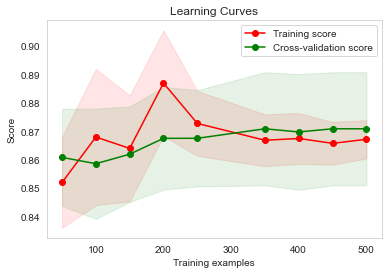

In [89]:
title='Learning Curves'
plot_learning_curve(RandomForestClassifier(**rf_parameters),title,X,Y,cv=None,n_jobs=4,train_sizes=[50,100,150,200,250,350,400 ,450,500])
plt.show()